In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#file_path = '/content/drive/My Drive/lit-review/query-results/scopus_06052024_QA.csv'
#file_path = '/content/drive/My Drive/lit-review/query-results/queryA_gs-scopus-results.csv'
file_path = '/content/drive/My Drive/lit-review/query-results/queryA_gs_scopus_cleaned.csv'


In [5]:
#defining my worksheet
worksheet = gc.open('queryA_gs_scopus_cleaned').sheet1
#get_all_values gives a list of rows
rows = worksheet.get_all_values()
#Convert to a DataFrame
df = pd.DataFrame(rows)
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header

In [7]:
df.keys()

Index(['1', 'ENTRYTYPE', 'author', 'bib-gs_bronze_gquerya',
       'bib-scopus_bronze_querya', 'booktitle', 'doi', 'isbn', 'issn',
       'journal',
       ...
       'evaluation-cider', 'evaluation-meteor', 'evaluation-bertscore',
       'Clinical Domain', 'privacy-evaluation', 'privacy-evaluation notes',
       'Summary', 'Conclusion', 'Notes', 'REPO'],
      dtype='object', name=0, length=133)

In [8]:
include_df = df[df["assessment"].isin(["DP", "CL","SD","DP-SD","DP-CL","CL-SD","DP-CL-SD"])]
include_df["year"] = include_df["year"].astype(int)
total_count = len(df)
inclusion_count = len(include_df)

include_df["multi_PET"] =  np.where(include_df['assessment'].isin(["DP-SD","DP-CL","CL-SD","DP-CL-SD"]), 1, 0).astype(int)

print(f"Final Inclusion is {inclusion_count} out of {total_count} or {inclusion_count/total_count*100}")
print(include_df["multi_PET"].sum())

Final Inclusion is 44 out of 460 or 9.565217391304348
8


<ipython-input-8-d86f2d8ebb5d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_df["year"] = include_df["year"].astype(int)
<ipython-input-8-d86f2d8ebb5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_df["multi_PET"] =  np.where(include_df['assessment'].isin(["DP-SD","DP-CL","CL-SD","DP-CL-SD"]), 1, 0).astype(int)


<ipython-input-35-b491035b29b4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(include_df["assessment"],order = include_df["assessment"].value_counts().index,palette=color_map)


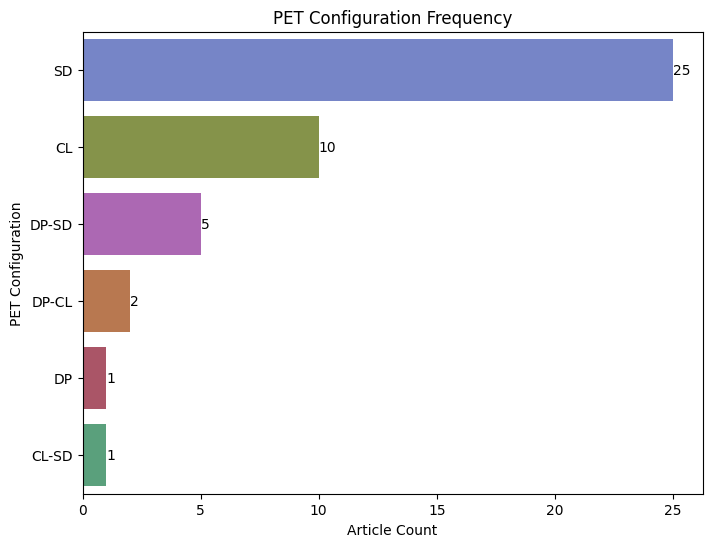

In [35]:
fig = plt.figure(figsize=(8,6))
color_map = {'DP':'#b8475f','CL':'#8c9f3e','SD':'#697cd4','DP-CL':'#ca743e','DP-SD':'#b65cbf','CL-SD':'#4eac7c','DP-CL-SD':'Black'}

ax = sns.countplot(include_df["assessment"],order = include_df["assessment"].value_counts().index,palette=color_map)
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlabel('Article Count')
ax.set_ylabel('PET Configuration')
ax.set_title("PET Configuration Frequency")
ax
fig.savefig('/content/drive/My Drive/lit-review/article-count-by-pet-type.png')

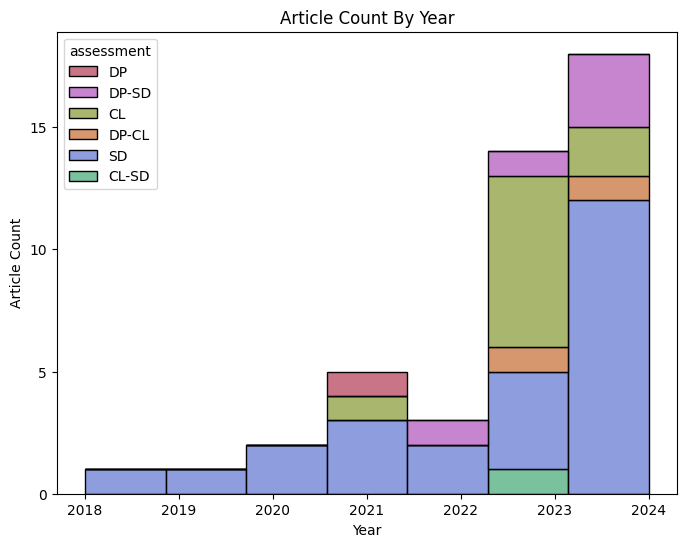

In [10]:
fig = plt.figure(figsize=(8,6))
ax = sns.histplot(include_df, x="year", hue="assessment",palette=color_map,multiple="stack")
ax.set_xlabel('Year')
ax.set_ylabel('Article Count')
ax.set_title("Article Count By Year")
ax.locator_params(axis='y', integer=True)
ax
fig.savefig('/content/drive/My Drive/lit-review/article-count-by-pet-type-and-year.png')

In [11]:

article_source_counts = { \
                        "total":len(df), \
                        "gs_total":len(df[df["bib-gs_bronze_gquerya"]=="1"]), \
                         "scopus_total":len(df[df["bib-scopus_bronze_querya"]=="1"]), \
                         "gs_include":len(include_df[(include_df["bib-gs_bronze_gquerya"]=="1") & (include_df["bib-scopus_bronze_querya"]=="0")]), \
                         "scopus_include":len(include_df[(include_df["bib-scopus_bronze_querya"]=="1") & (include_df["bib-gs_bronze_gquerya"]=="0")]), \
                         "both_include":len(include_df[(include_df["bib-scopus_bronze_querya"]=="1") & (include_df["bib-gs_bronze_gquerya"]=="1")]), \
                         "include_all":len(include_df[(include_df["bib-scopus_bronze_querya"]=="1") | (include_df["bib-gs_bronze_gquerya"]=="1")])
                        }
article_source_counts

{'total': 460,
 'gs_total': 205,
 'scopus_total': 264,
 'gs_include': 11,
 'scopus_include': 29,
 'both_include': 4,
 'include_all': 44}

In [12]:
data_type_mapping = {
    ('0', '1', '0'): 'Text',
    ('1', '0', '0'): 'Tabular',
    ('0', '0', '1'): 'Image',
    ('1', '1', '0'): 'Tabular and Text',
    ('1', '0', '1'): 'Tabular and Image',
    ('0', '1', '1'): 'Text and Image',
    ('1', '1', '1'): 'Tabular and Text and Image',
}

source_mapping = {
    ('1', '0'): 'Google Scholar',
    ('0', '1'): 'Scopus',
    ('1', '1'): 'GS and Scopus',
}

def map_data_type_values(row):
    key = (row["data-type-tabular"], row["data-type-text"], row["data-type-image"])
    return data_type_mapping.get(key, None)

def map_source_values(row):
    key = (row["bib-gs_bronze_gquerya"], row["bib-scopus_bronze_querya"])
    return source_mapping.get(key, None)

include_df['data_type'] = include_df.apply(map_data_type_values, axis=1)
include_df['source_type'] = include_df.apply(map_source_values, axis=1)


<ipython-input-12-d518fa670038>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_df['data_type'] = include_df.apply(map_data_type_values, axis=1)
<ipython-input-12-d518fa670038>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_df['source_type'] = include_df.apply(map_source_values, axis=1)


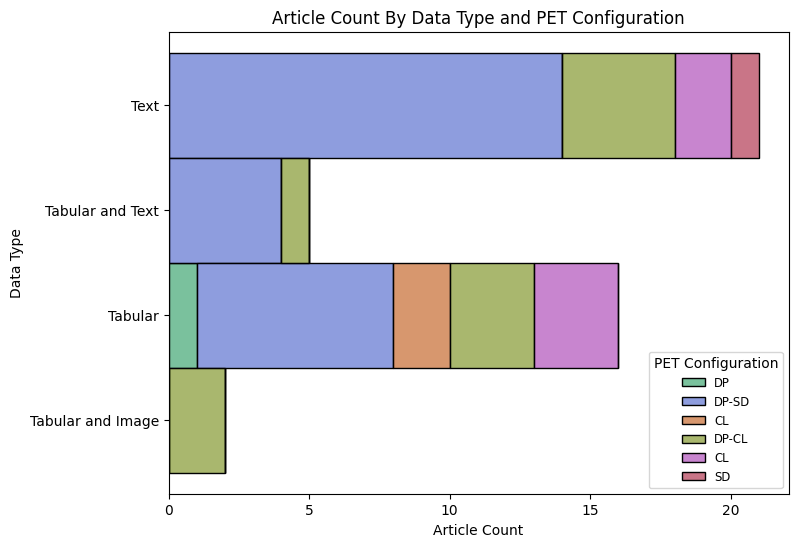

In [31]:
fig = plt.figure(figsize=(8,6))
ax = sns.histplot(include_df, y="data_type", hue="assessment",palette=color_map,multiple="stack")
ax.set_xlabel('Article Count')
ax.set_ylabel('Data Type')
ax.set_title("Article Count By Data Type and PET Configuration")
ax.locator_params(axis='x', integer=True)
legend = plt.legend(include_df["assessment"], title="PET Configuration",
                    loc=4, fontsize='small', fancybox=True)
# for container in ax.containers:
#     ax.bar_label(container)
ax
fig.savefig('/content/drive/My Drive/lit-review/article-count-by-data-type.png')

<ipython-input-14-b129127af2b6>:6: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  ax.locator_params(axis='y', integer=True)


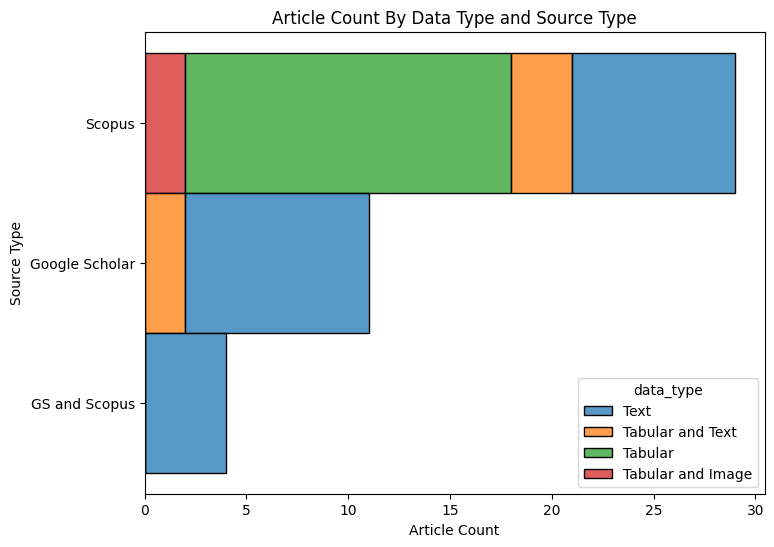

In [14]:
fig = plt.figure(figsize=(8,6))
ax = sns.histplot(include_df, y="source_type", hue="data_type",multiple="stack")#,palette=color_map,multiple="stack")
ax.set_xlabel('Article Count')
ax.set_ylabel('Source Type')
ax.set_title("Article Count By Data Type and Source Type")
ax.locator_params(axis='y', integer=True)
ax
fig.savefig('/content/drive/My Drive/lit-review/articles-by-data-and-source-type.png')

<ipython-input-16-a6a1492f51fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_df["any_CL"] =  np.where(include_df['assessment'].isin(["CL","DP-CL","CL-SD","DP-CL-SD"]), 1, 0).astype(int)
<ipython-input-16-a6a1492f51fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_df["any_DP"] =  np.where(include_df['assessment'].isin(["DP","DP-CL","DP-SD","DP-CL-SD"]), 1, 0).astype(int)
<ipython-input-16-a6a1492f51fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

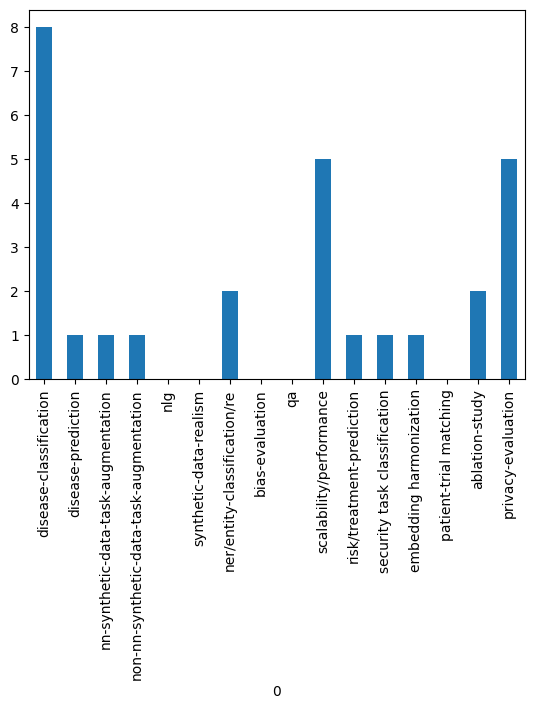

In [16]:
include_df["any_CL"] =  np.where(include_df['assessment'].isin(["CL","DP-CL","CL-SD","DP-CL-SD"]), 1, 0).astype(int)
include_df["any_DP"] =  np.where(include_df['assessment'].isin(["DP","DP-CL","DP-SD","DP-CL-SD"]), 1, 0).astype(int)
include_df["any_SD"] =  np.where(include_df['assessment'].isin(["SD","CL-SD","DP-SD","DP-CL-SD"]), 1, 0).astype(int)

# Calculate the sum of each column
task_sums_all = include_df[['disease-classification','disease-prediction',\
                        'nn-synthetic-data-task-augmentation','non-nn-synthetic-data-task-augmentation',\
                        'nlg','synthetic-data-realism','ner/entity-classification/re','bias-evaluation','qa','scalability/performance',\
                        'risk/treatment-prediction','security task classification','embedding harmonization',\
                        'patient-trial matching','ablation-study','privacy-evaluation']].apply(pd.to_numeric).sum()

cl_task_sums = include_df[include_df["any_CL"] == 1][['disease-classification','disease-prediction',\
                        'nn-synthetic-data-task-augmentation','non-nn-synthetic-data-task-augmentation',\
                        'nlg','synthetic-data-realism','ner/entity-classification/re','bias-evaluation','qa','scalability/performance',\
                        'risk/treatment-prediction','security task classification','embedding harmonization',\
                        'patient-trial matching','ablation-study','privacy-evaluation']].apply(pd.to_numeric).sum()

dp_task_sums = include_df[include_df["any_DP"] == 1][['disease-classification','disease-prediction',\
                        'nn-synthetic-data-task-augmentation','non-nn-synthetic-data-task-augmentation',\
                        'nlg','synthetic-data-realism','ner/entity-classification/re','bias-evaluation','qa','scalability/performance',\
                        'risk/treatment-prediction','security task classification','embedding harmonization',\
                        'patient-trial matching','ablation-study','privacy-evaluation']].apply(pd.to_numeric).sum()

sd_task_sums = include_df[include_df["any_SD"] == 1][['disease-classification','disease-prediction',\
                        'nn-synthetic-data-task-augmentation','non-nn-synthetic-data-task-augmentation',\
                        'nlg','synthetic-data-realism','ner/entity-classification/re','bias-evaluation','qa','scalability/performance',\
                        'risk/treatment-prediction','security task classification','embedding harmonization',\
                        'patient-trial matching','ablation-study','privacy-evaluation']].apply(pd.to_numeric).sum()


# Plot the sums as a bar chart
cl_task_sums.plot(kind='bar')
plt.savefig('/content/drive/My Drive/lit-review/cl_task_sums.png')



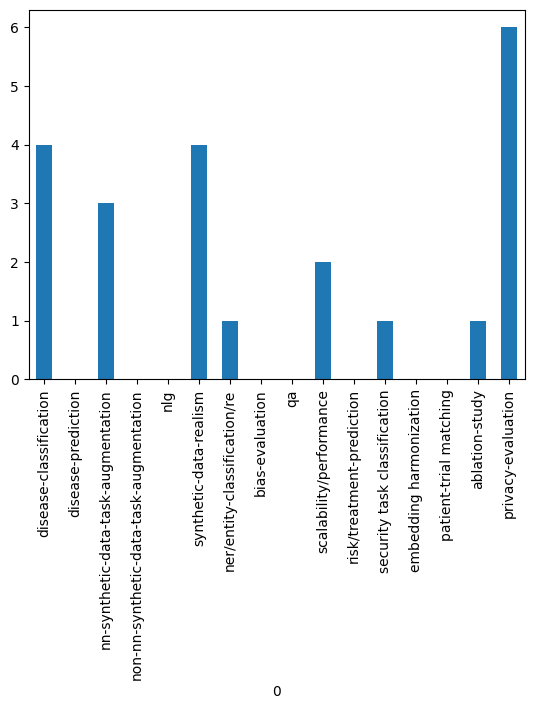

In [17]:
dp_task_sums.plot(kind='bar')
plt.savefig('/content/drive/My Drive/lit-review/dp_task_sums.png')


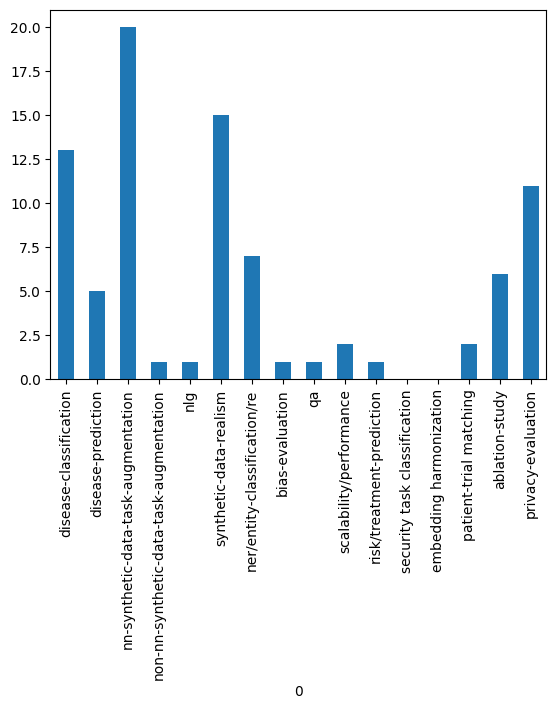

In [18]:
sd_task_sums.plot(kind='bar')
plt.savefig('/content/drive/My Drive/lit-review/sd_task_sums.png')

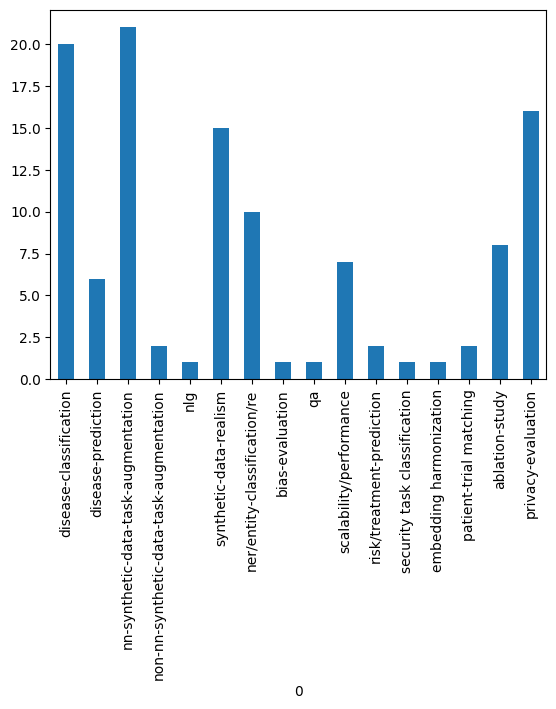

In [19]:
task_sums_all.plot(kind='bar')
plt.savefig('/content/drive/My Drive/lit-review/task_sums_all.png')


## Privacy Evaluation Analysis

In [20]:
len(include_df[include_df["any_CL"] == 1])
len(include_df[include_df["any_DP"] == 1])
len(include_df[include_df["any_SD"] == 1])

include_df["privacy-evaluation"].replace('', np.nan, inplace=True)
include_df.dropna(subset=['privacy-evaluation'], inplace=True)
include_df["privacy-evaluation"] = include_df["privacy-evaluation"].astype(int)
include_df["any_CL"].value_counts()


<ipython-input-20-a6adbe67fd2e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_df["privacy-evaluation"].replace('', np.nan, inplace=True)
<ipython-input-20-a6adbe67fd2e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_df.dropna(subset=['privacy-evaluation'], inplace=True)
<ipython-input-20-a6adbe67fd2e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_d

any_CL
0    31
1    13
Name: count, dtype: int64

<ipython-input-21-2756937b7d08>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_df["privacy-evaluation"] = include_df["privacy-evaluation"].astype(int)


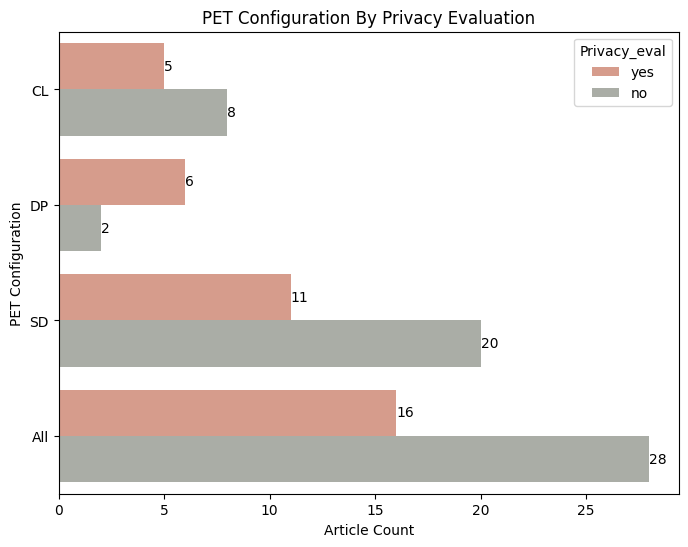

In [21]:
fig = plt.figure(figsize=(8,6))

include_df["privacy-evaluation"] = include_df["privacy-evaluation"].astype(int)

privacy_counts = [
    ["CL", 'yes', len(include_df[(include_df["any_CL"]==1) & (include_df["privacy-evaluation"]==1)])],
    ["DP", 'yes', len(include_df[(include_df["any_DP"]==1) & (include_df["privacy-evaluation"]==1)])],
    ["SD", 'yes', len(include_df[(include_df["any_SD"]==1) & (include_df["privacy-evaluation"]==1)])],
    ["All", "yes", len(include_df[include_df["privacy-evaluation"]==1])],
    ["CL", 'no', len(include_df[(include_df["any_CL"]==1) & (include_df["privacy-evaluation"]==0)])],
    ["DP", 'no', len(include_df[(include_df["any_DP"]==1) & (include_df["privacy-evaluation"]==0)])],
    ["SD", 'no', len(include_df[(include_df["any_SD"]==1) & (include_df["privacy-evaluation"]==0)])],
    ["All", "no", len(include_df[include_df["privacy-evaluation"]==0])],
  ]


privacy_df = pd.DataFrame(privacy_counts, columns=["PET Type", "Privacy_eval", "Privacy Count"])


ax = sns.barplot(
    x='Privacy Count',
    y='PET Type',
    hue='Privacy_eval',
    data=privacy_df,
    palette={'yes': "#e29580", 'no': "#aaaea5"},
)

ax.set_xlabel('Article Count')
ax.set_ylabel('PET Configuration')
ax.set_title("PET Configuration By Privacy Evaluation")
ax.locator_params(axis='x', integer=True)
for container in ax.containers:
    ax.bar_label(container)
ax
fig.savefig('/content/drive/My Drive/lit-review/pet-by-privacy-eval.png')

In [22]:
cl_priv_count = privacy_df[(privacy_df['PET Type']=='CL') & (privacy_df['Privacy_eval']=='yes')]['Privacy Count'].iloc[0]
cl_priv_per = cl_priv_count/privacy_df[(privacy_df['PET Type']=='CL')]['Privacy Count'].sum()

dp_priv_count = privacy_df[(privacy_df['PET Type']=='DP') & (privacy_df['Privacy_eval']=='yes')]['Privacy Count'].iloc[0]
dp_priv_per = dp_priv_count/privacy_df[(privacy_df['PET Type']=='DP')]['Privacy Count'].sum()

sd_priv_count = privacy_df[(privacy_df['PET Type']=='SD') & (privacy_df['Privacy_eval']=='yes')]['Privacy Count'].iloc[0]
sd_priv_per = sd_priv_count/privacy_df[(privacy_df['PET Type']=='SD')]['Privacy Count'].sum()

all_priv_count = privacy_df[(privacy_df['PET Type']=='All') & (privacy_df['Privacy_eval']=='yes')]['Privacy Count'].iloc[0]
all_priv_per = all_priv_count/privacy_df[(privacy_df['PET Type']=='All')]['Privacy Count'].sum()


print(f"{cl_priv_per} of studies - {cl_priv_count} studies -  with Collaborative learning (CL) conducted privacy analysis")
print(f"{dp_priv_per} of studies - {dp_priv_count} studies - with Differential Privacy (DP) conducted privacy analysis")
print(f"{sd_priv_per} of studies - {sd_priv_count} studies - with Synthetic Data (SD) conducted privacy analysis")
print(f"{all_priv_per} of studies - {all_priv_count} studies - conducted privacy analysis")

0.38461538461538464 of studies - 5 studies -  with Collaborative learning (CL) conducted privacy analysis
0.75 of studies - 6 studies - with Differential Privacy (DP) conducted privacy analysis
0.3548387096774194 of studies - 11 studies - with Synthetic Data (SD) conducted privacy analysis
0.36363636363636365 of studies - 16 studies - conducted privacy analysis


<ipython-input-23-ce6f7ca2f69f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  include_df["privacy-evaluation"] = include_df["privacy-evaluation"].astype(int)


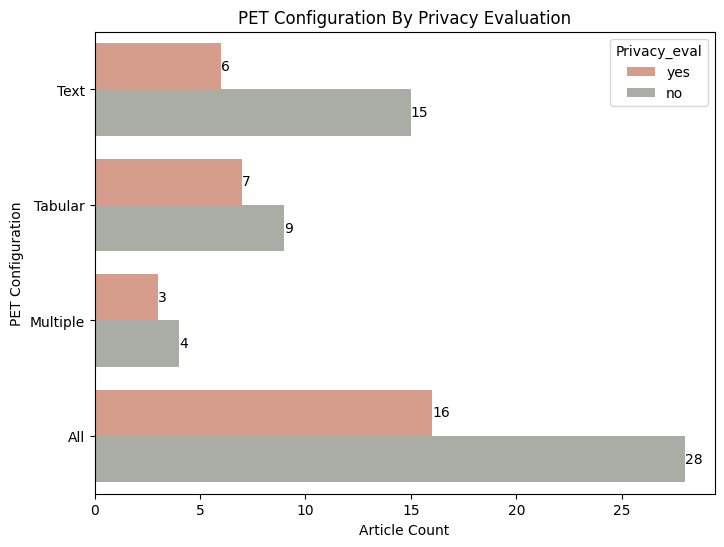

In [23]:
fig = plt.figure(figsize=(8,6))

include_df["privacy-evaluation"] = include_df["privacy-evaluation"].astype(int)

privacy_counts = [
    ["Text", 'yes', len(include_df[(include_df["data_type"].isin(['Text'])) & (include_df["privacy-evaluation"]==1)])],
    ["Tabular", 'yes', len(include_df[(include_df["data_type"].isin(['Tabular'])) & (include_df["privacy-evaluation"]==1)])],
    ["Multiple", 'yes', len(include_df[(include_df["data_type"].isin(['Tabular and Text','Tabular and Image','Text and Image'])) & (include_df["privacy-evaluation"]==1)])],
    ["All", "yes", len(include_df[include_df["privacy-evaluation"]==1])],
    ["Text", 'no', len(include_df[(include_df["data_type"].isin(['Text'])) & (include_df["privacy-evaluation"]==0)])],
    ["Tabular", 'no', len(include_df[(include_df["data_type"].isin(['Tabular'])) & (include_df["privacy-evaluation"]==0)])],
    ["Multiple", 'no', len(include_df[(include_df["data_type"].isin(['Tabular and Text','Tabular and Image','Text and Image'])) & (include_df["privacy-evaluation"]==0)])],
    ["All", "no", len(include_df[include_df["privacy-evaluation"]==0])],
  ]


privacy_df = pd.DataFrame(privacy_counts, columns=["Data Type", "Privacy_eval", "Privacy Count"])


ax = sns.barplot(
    x='Privacy Count',
    y='Data Type',
    hue='Privacy_eval',
    data=privacy_df,
    palette={'yes': "#e29580", 'no': "#aaaea5"},
)

ax.set_xlabel('Article Count')
ax.set_ylabel('PET Configuration')
ax.set_title("PET Configuration By Privacy Evaluation")
ax.locator_params(axis='x', integer=True)
for container in ax.containers:
    ax.bar_label(container)
ax
fig.savefig('/content/drive/My Drive/lit-review/data-type-by-privacy-eval.png')

In [24]:
text_priv_count = privacy_df[(privacy_df['Data Type']=='Text') & (privacy_df['Privacy_eval']=='yes')]['Privacy Count'].iloc[0]
text_priv_per = text_priv_count/privacy_df[(privacy_df['Data Type']=='Text')]['Privacy Count'].sum()

tab_priv_count = privacy_df[(privacy_df['Data Type']=='Tabular') & (privacy_df['Privacy_eval']=='yes')]['Privacy Count'].iloc[0]
tab_priv_per = tab_priv_count/privacy_df[(privacy_df['Data Type']=='Tabular')]['Privacy Count'].sum()

both_priv_count = privacy_df[(privacy_df['Data Type']=='Multiple') & (privacy_df['Privacy_eval']=='yes')]['Privacy Count'].iloc[0]
both_priv_per = both_priv_count/privacy_df[(privacy_df['Data Type']=='Multiple')]['Privacy Count'].sum()


all_data_priv_count = privacy_df[(privacy_df['Data Type']=='All') & (privacy_df['Privacy_eval']=='yes')]['Privacy Count'].iloc[0]
all_data_priv_per = all_data_priv_count/privacy_df[(privacy_df['Data Type']=='All')]['Privacy Count'].sum()


print(f"{text_priv_per} of studies - {text_priv_count} studies -  with Textual Data conducted privacy analysis")
print(f"{tab_priv_per} of studies - {tab_priv_count} studies - with Tabular Data conducted privacy analysis")
print(f"{both_priv_per} of studies - {both_priv_count} studies - with multiple Data conducted privacy analysis")
print(f"{all_data_priv_per} of studies - {all_data_priv_count} studies - conducted privacy analysis")

0.2857142857142857 of studies - 6 studies -  with Textual Data conducted privacy analysis
0.4375 of studies - 7 studies - with Tabular Data conducted privacy analysis
0.42857142857142855 of studies - 3 studies - with multiple Data conducted privacy analysis
0.36363636363636365 of studies - 16 studies - conducted privacy analysis


In [25]:
#df_inlcude.value_counts(['PET C','disease-classification',
#       'disease-prediction', 'synthetic-data-generation',
#       'entity-classification/re', 'bias-evaluation', 'qa',
#       'risk/treatment-prediction', 'scalability/performance',
#       'security task classification', 'embedding harmonization',
#       'patient-trial matching'])


df_inlcude.value_counts(['PET C','synthetic-data-generation','privacy-evaluation'])

NameError: name 'df_inlcude' is not defined